# Generative Adversarial Network

## Pre-processing data

In [1]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import os
import cv2
tf.reset_default_graph()

In [2]:
    
## Here we will get the 100 000 first images and put them in a variable 178*218*3
## Here we will get the 100 000 first images and put them in a variable 178*218*3
dataset_size =202590

        
def get_batch(batch_size):
        indexes = np.random.randint(1, dataset_size + 1, batch_size)
        data = []
        imgname = "img_align_celeba_64/"
        for i in indexes:
            #image = tf.read_file(imgname + str(i).zfill(6) + ".jpg")
            #image = tf.image.decode_jpeg(image, channels=3)
            image = mpimg.imread(imgname + str(i).zfill(6) + ".jpg")
            # Normalizing & centering images
            #image = image - np.mean(image)
            #image = image / np.var(image)
            image = (image/255.)
            data.append(image)
        return np.array(data)

def sample_Z(batch_size=50, n=128):
        return np.random.uniform(-1., 1., size=[batch_size, n])

In [3]:
def generator_mlp(Z, fc_sizes=[110,200,300], output_dim=64*64*3, reuse=False):
    
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        fc1 = tf.layers.dense(Z, fc_sizes[0], activation=tf.nn.leaky_relu)
        fc2 = tf.layers.dense(fc1, fc_sizes[1], activation=tf.nn.leaky_relu)
        fc3 = tf.layers.dense(fc2, fc_sizes[2], activation=tf.nn.leaky_relu)
        out = tf.layers.dense(fc3, output_dim)
        out = tf.reshape(out, shape=(tf.shape(out)[0],64,64,3))
    return out


In [4]:
def discriminator_cnn(X, fc_sizes=[110,300,200], reuse=False, alpha=0.2, keep_prob=0.5):
    
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        # Input layer is 218x178x3
        # Convolutional layer, 109x89x64
        conv1 = tf.layers.conv2d(X, 64, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        drop1 = tf.layers.dropout(lrelu1, keep_prob)
        
        # Strided convolutional layer, 55x45x128
        conv2 = tf.layers.conv2d(drop1, 128, 5, 2, 'same', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(lrelu2, keep_prob)
        
        # Strided convolutional layer, 28x23x256
        conv3 = tf.layers.conv2d(drop2, 256, 5, 2, 'same', use_bias=False)
        bn3 = tf.layers.batch_normalization(conv3)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.layers.dropout(lrelu3, keep_prob)
        
        # fully connected
        flat = tf.reshape(drop3, (-1, 8*8*256))
        out = tf.layers.dense(flat, 1)
        
        return out

In [5]:
X = tf.placeholder(tf.float32,[None,64,64,3])
XX = tf.reshape(X, shape=(tf.shape(X)[0], 64*64*3))
Z = tf.placeholder(tf.float32,[None,128])

In [7]:
X_fake = generator_mlp(Z)
true_data_logits = discriminator_mlp(X)
fake_data_logits = discriminator_mlp(X_fake, reuse=True)

In [8]:
D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_data_logits,labels=tf.ones_like(true_data_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_data_logits,labels=tf.zeros_like(fake_data_logits)))
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_data_logits,labels=tf.ones_like(fake_data_logits)))


In [9]:
G_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Generator")
D_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Discriminator")

G_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(G_loss,var_list = G_variables) # G Train step
D_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(D_loss,var_list = D_variables) # D Train step


In [ ]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 1200

for i in range(100):
    X_batch = get_batch(batch_size)
    Z_batch = sample_Z(batch_size, 128)
    _, Dloss = sess.run([D_step, D_loss], feed_dict={X: X_batch, Z: Z_batch})
    _, Gloss = sess.run([G_step, G_loss], feed_dict={Z: Z_batch})

    print("N: %d\t D_loss: %.4f\t G_loss: %.4f"%(i,Dloss,Gloss))
Z_batch = sample_Z(1, 128)
X_batch = get_batch(1)
sess.run(X_fake, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(X_fake, shape=(64,64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

Iterations: 0	 Discriminator loss: 1.3664	 Generator loss: 0.6910
Iterations: 1	 Discriminator loss: 1.3589	 Generator loss: 0.6908
Iterations: 2	 Discriminator loss: 1.3503	 Generator loss: 0.6906
Iterations: 3	 Discriminator loss: 1.3412	 Generator loss: 0.6905
Iterations: 4	 Discriminator loss: 1.3322	 Generator loss: 0.6902
Iterations: 5	 Discriminator loss: 1.3222	 Generator loss: 0.6901
Iterations: 6	 Discriminator loss: 1.3116	 Generator loss: 0.6899
Iterations: 7	 Discriminator loss: 1.3014	 Generator loss: 0.6897
Iterations: 8	 Discriminator loss: 1.2891	 Generator loss: 0.6895
Iterations: 9	 Discriminator loss: 1.2775	 Generator loss: 0.6892
Iterations: 10	 Discriminator loss: 1.2650	 Generator loss: 0.6891
Iterations: 11	 Discriminator loss: 1.2516	 Generator loss: 0.6888
Iterations: 12	 Discriminator loss: 1.2357	 Generator loss: 0.6886
Iterations: 13	 Discriminator loss: 1.2204	 Generator loss: 0.6883
Iterations: 14	 Discriminator loss: 1.2017	 Generator loss: 0.6881
Itera

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


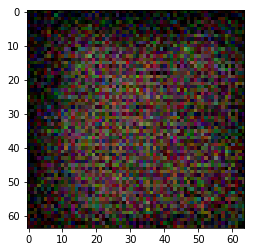

In [15]:
Z_batch = sample_Z(1, 128)
X_batch = get_batch(1)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(64,64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

In [14]:
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(X_fake, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(X_fake, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

NameError: name 'dataset' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


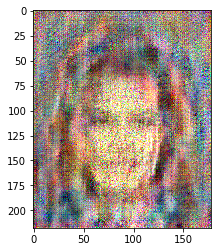

In [51]:
Z_batch = sample_Z(1, 100)
X_batch = get_batch(1, dataset)
sess.run(X_fake, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(X_fake, shape=(218,178,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))